*Ce fichier est rendu compilé. Ainsi, la plupart des commentaires (accuracy, temps de calcul) correspondent aux données du fichier rendu.*

In [ ]:
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import math
import collections
import warnings
import sys
import tensorflow as tf
import tensorflow 
from tensorflow import keras
from sklearn import neighbors 
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier


In [ ]:
data = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
# Ce dataset est composé de 60 000 exemples pour le Training_set et 10 000 exemples pour le Test_set
# Chaque exemples est une image de 28*28 (soit 784 pixels, pixels prenant une valeur de 0-255) en niveau de gris.
# Une image (label contenu dans les Y) peut correspondre à 10 types d'images differents

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Transformation Matrice (nb_image, 28, 28) en (nb_image, 784)
X_trainRS  = X_train.reshape(X_train.shape[0], 784)
X_testRS   = X_test.reshape(X_test.shape[0], 784)
print(np.shape(X_trainRS))


(60000, 784)


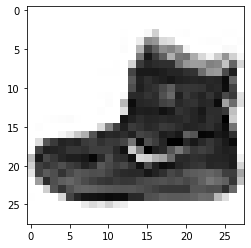

9


In [ ]:
img_to_display = 0

plt.imshow(X_train[img_to_display], cmap = cm.Greys)
plt.show()
print(y_train[img_to_display])

In [ ]:
# #parcours du corpus pour en extraire ses caractéristiques techniques
# num_pixels = X_train.shape[1] * X_train.shape[2]
# dim_corpus = X_train.shape
# dim_corpus

(60000, 28, 28)

#Initialisation des data par ACP

In [ ]:
# On reconstitue le dataset originel
X = np.concatenate((data[0][0], data[1][0]), axis=0)
X = X.reshape(X.shape[0], 784) # on met les pixels sur un vecteur ligne

Y = np.concatenate((data[0][1], data[1][1]), axis=0)

In [ ]:
# Pré-traitement des données :
# On centre et on reduit les données initiales dans l'intervalle [0,1]
# Ainsi les variables deviennent comparables car elles sont sans unité.

# Un pixel est dans [0, 255], on divise donc par 255 pour normaliser
NX= np.divide(X, 255)

# Puis on centre les données
XMean = NX.mean(axis=0)
NNX = NX - XMean

In [ ]:
# Initialise ACP
pca = PCA()

#Entraine
fitted = pca.fit_transform(NNX)

1.0000000000000002


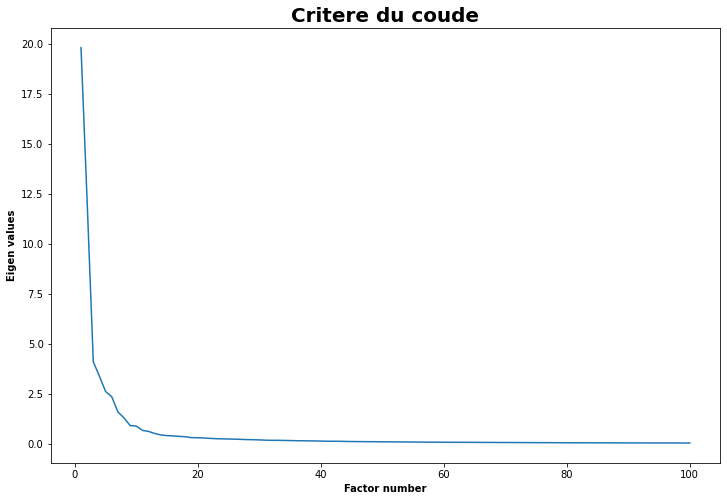

In [ ]:
print(pca.explained_variance_ratio_.sum()) # 100% de la variabilté est bien expliqué par nos variables

#On recupere l'ensemble des valeurs propres (variances des axes / variances dans la direction de son vecteur propre associé)
eigval = pca.explained_variance_ 

p = NNX.shape[1] #nombre d'axe = 784

#On peut alors afficher l'ebouli qui nous donne une idée du nombre d'axe a garder

fig = plt.figure(figsize=(12,8))
# Nous avons decider de ne garder que les 100 premieres variables pour un meilleur affichage
plt.plot(np.arange(1,101),eigval[:100]) 
plt.title("Critere du coude", fontweight = 'bold', fontsize=20) 
plt.ylabel("Eigen values", fontweight = 'bold') 
plt.xlabel("Factor number", fontweight = 'bold') 
plt.show()

In [ ]:
print(pca.explained_variance_ratio_[:84].sum())
# En tatonnant sur l'explication de la variance total par X variables, nous avons trouvé que 84 variables permettent d'expliquer 90% de la variance total de notre dataset, 
# permettant ainsi une bonne réduction du nuage de points originel. Nous allons donc faire une réduction par ACP vers 84 variables

pca = PCA(n_components=84)
ACP_84D = pca.fit_transform(NNX)

0.9005486931904886


Text(0.5, 1.0, 'Label')

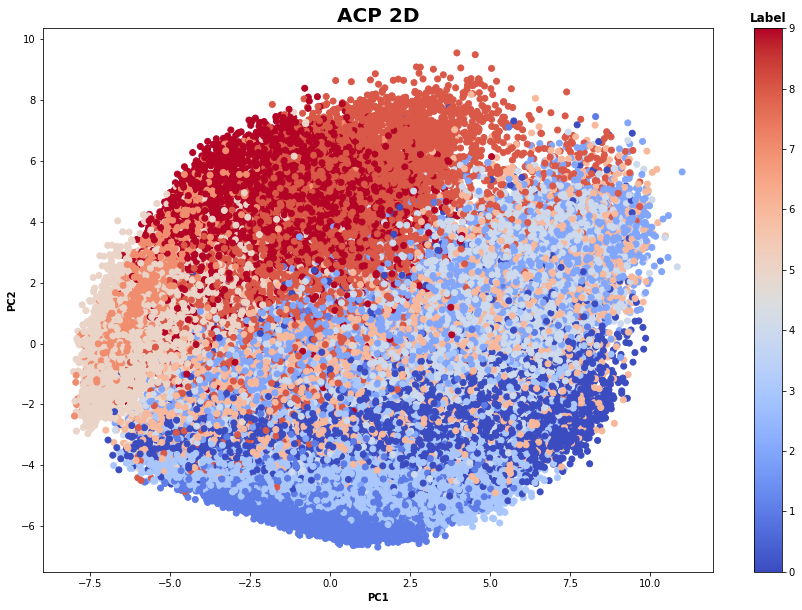

In [ ]:
#Neanmmoins, pour visualiser les données il ne faut garder que 2 axes
plt.figure(figsize=(15,10))

pca = PCA(n_components=2)
ACP_2D = pca.fit_transform(NNX)

graph = plt.scatter(ACP_2D[:, 0], ACP_2D[:, 1], c=Y, cmap=plt.cm.coolwarm)
plt.title('ACP 2D', fontweight = 'bold', fontsize=20)
plt.xlabel("PC1",fontweight = 'bold')
plt.ylabel("PC2",fontweight = 'bold')
col = plt.colorbar(graph)
col.ax.set_title('Label',fontweight = 'bold')

In [ ]:
# Données d'entrainement utilisées par la suite pour les tests ACP :

X_train84D, X_test84D, y_train84D, y_test84D = train_test_split(ACP_84D, Y)

# Initialisation des data par LDA


[0.44775652 0.21875177 0.09237004 0.07396008 0.06062643 0.04305586
 0.03801965 0.01584194 0.00961772]


Text(0.5, 1.0, 'Label')

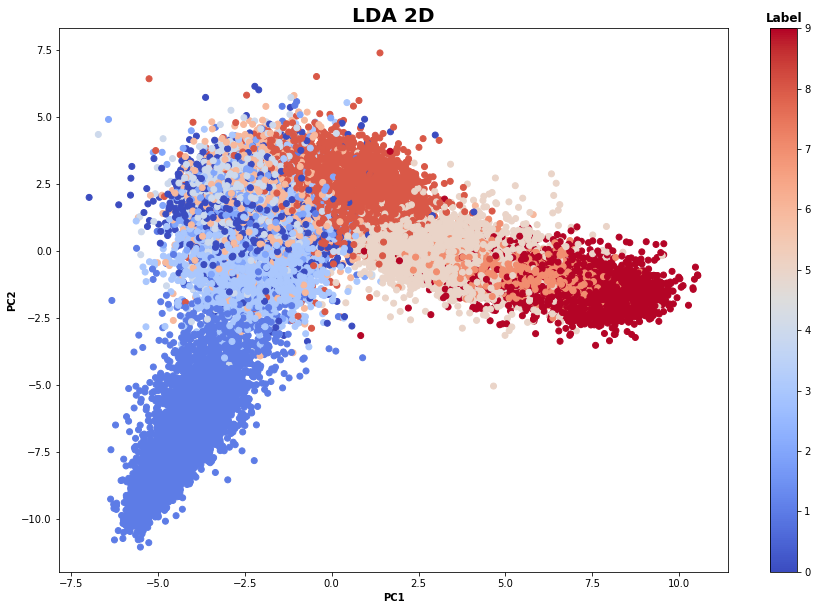

In [ ]:
lda = LinearDiscriminantAnalysis()

X_LDA = lda.fit(X, Y).transform(X)

print(lda.explained_variance_ratio_)

plt.figure(figsize=(15,10))
graph = plt.scatter(X_LDA[:, 0], X_LDA[:, 1], c=Y, cmap=plt.cm.coolwarm)
plt.title('LDA 2D', fontweight = 'bold', fontsize=20)
plt.xlabel("PC1",fontweight = 'bold')
plt.ylabel("PC2",fontweight = 'bold')
col = plt.colorbar(graph)
col.ax.set_title('Label',fontweight = 'bold')

# On remarque que les classes sont mieux séparées qu'une ACP2D, mais que le nuage de points a perdu de sa variance originelle

In [ ]:
print(lda.explained_variance_ratio_.sum())


0.9999999999999999


In [ ]:
print(lda.explained_variance_ratio_)

X_trainLDA, X_testLDA, y_trainLDA, y_testLDA = train_test_split(X_LDA, Y)

[0.44775652 0.21875177 0.09237004 0.07396008 0.06062643 0.04305586
 0.03801965 0.01584194 0.00961772]


# Classifieur KNN
*Attention les cellules pour trouver le K optimial prennent beaucoup de temps à tourner. Nous vous conseillons de ne pas les relancer.*


## Sans réduction

In [ ]:
# Chaque X_testKNN sera un set de 784 pixels, representée par une image.
# Lors de notre classification KNN, on comparera le label de notre image y_test, avec le label des K plus proches images.

print(np.shape(X_testRS))
# X_test2D[0]

(10000, 784)


Text(0, 0.5, 'Accuracy')

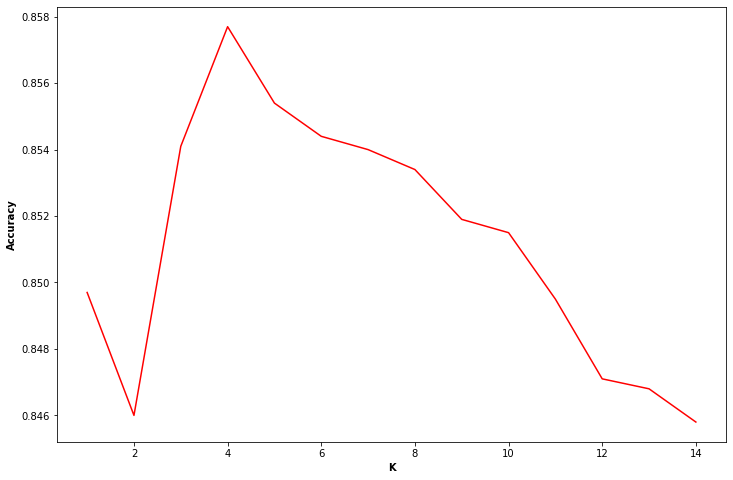

In [ ]:
# !! ATTENTION ne pas relancer l'exécution (long à tourner) !!

# Trouvons le k maximisant l'accuracy du model

f1_list=[]
k_list=[]
for k in range(1,15):
    #Entrainement du classifieur
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_trainRS, y_train)
    #prediction de notre ensemble de test
    y_pred = knn.predict(X_testRS)

    cm = confusion_matrix(y_test, y_pred)
    #verfication de l'accuracy par notre matrice de confusion
    acc = np.sum(np.diag(cm))/np.sum(cm)
    #on sauvegarde l'accuracy pour un k donné
    f1_list.append(acc)
    k_list.append(k)

plt.figure(figsize=(12,8))    
plt.plot(k_list,f1_list, c="red")
plt.xlabel("K",fontweight = 'bold')
plt.ylabel("Accuracy",fontweight = 'bold')


In [ ]:
# On remarque que l'accuracy ne varie pas enormement entre les differentes valeurs de k testées (0.01).
# Mais nous allons quand même essayer de maximiser notre classifieur KNN en prenant un k de 4.

knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')

t = time()
knn.fit(X_trainRS, y_train)
t = time() - t

#prediction de notre ensemble de test
y_pred = knn.predict(X_testRS)

# Determinons l'accuracy de notre model entrainé
cm = confusion_matrix(y_test, y_pred)
acc = np.sum(np.diag(cm))/np.sum(cm)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

85.77%
Temps d'entrainement:  0.006749629974365234


## Avec ACP

Text(0, 0.5, 'Accuracy')

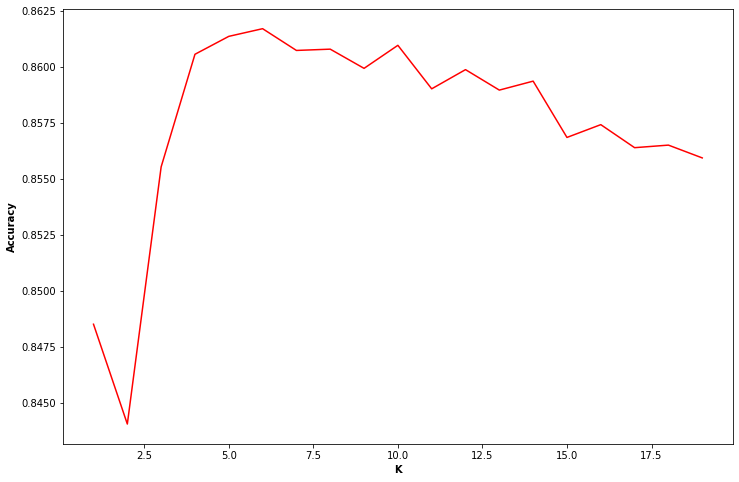

In [ ]:
# !! ATTENTION ne pas relancer l'exécution (long à tourner) !!

# Trouvons le k maximisant l'accuracy du model

f1_list=[]
k_list=[]
for k in range(1,20):
    #Entrainement du classifieur
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train84D, y_train84D)
    #prediction de notre ensemble de test
    y_pred = knn.predict(X_test84D)
    cm = confusion_matrix(y_test84D, y_pred)

    acc = np.sum(np.diag(cm))/np.sum(cm)
    #on sauvegarde l'accuracy pour un k donné
    
    f1_list.append(acc)
    k_list.append(k)
    
plt.figure(figsize=(12,8))    
plt.plot(k_list,f1_list, c="red")
plt.xlabel("K",fontweight = 'bold')
plt.ylabel("Accuracy",fontweight = 'bold')

In [ ]:
# Encore une fois, l'accuracy ne fluctue pas beaucoup, mais nous allons choisir k = 6
# afin de maximiser l'accuracy du model.

knn = KNeighborsClassifier(n_neighbors=6 , metric='euclidean')

t = time()
knn.fit(X_train84D, y_train84D)
t = time() - t

y_pred = knn.predict(X_test84D)

acc = accuracy_score(y_test84D, y_pred)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

86.17%
Temps d'entrainement:  0.013933897018432617


## Avec LDA

Text(0, 0.5, 'Accuracy')

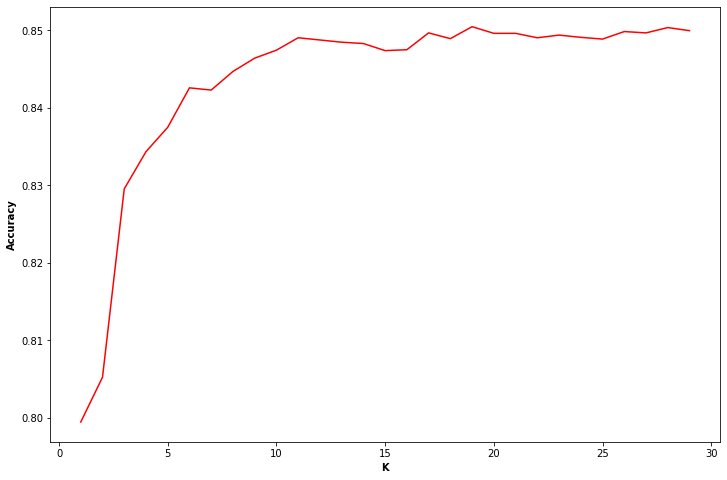

In [ ]:
# !! ATTENTION ne pas relancer l'exécution (long à tourner) !!

# Trouvons le k maximisant l'accuracy du model

f1_list=[]
k_list=[]
for k in range(1,30):
    #Entrainement du classifieur
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_trainLDA, y_trainLDA)
    #prediction de notre ensemble de test
    y_pred = knn.predict(X_testLDA)

    cm = confusion_matrix(y_testLDA, y_pred)
    #verfication de l'accuracy par notre matrice de confusion
    acc = np.sum(np.diag(cm))/np.sum(cm)
    #on sauvegarde l'accuracy pour un k donné
    f1_list.append(acc)
    k_list.append(k)

plt.figure(figsize=(12,8))    
plt.plot(k_list,f1_list, c="red")
plt.xlabel("K",fontweight = 'bold')
plt.ylabel("Accuracy",fontweight = 'bold')

In [ ]:
# Les données etant bien séparées, l'accuracy de k de 15 à au moins 100 fluctuent tres peu.
# Prenons k = 26, qui semble être un bonne valeur d'accuracy.

knn = KNeighborsClassifier(n_neighbors=26, metric='euclidean')

t = time()
knn.fit(X_trainLDA, y_trainLDA)
t = time() - t

y_pred = knn.predict(X_testLDA)

acc = accuracy_score(y_testLDA, y_pred)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

84.98%
Temps d'entrainement:  0.0960988998413086


## Conclusion KNN


*   Utiliser ce classifieur apres réduction de dimension pars ACP permet d'avoir un temps de calcul un peu plus long (prés de 2 fois plus long) et une meilleure précision (négligeable).

*   Utiliser ce classifieur apres réduction de dimension pars LDA permet d'avoir un temps de calcul un peu plus long également et une précision un peu inférieur à celle obtenu sans réduction de LDA. 

Pour cet ensemble de données, il semblerait qu'il n'est donc pas nécessaire d'utiliser une réduction par ACP ou par LDA.

# Classifieur Bayesien

## Sans réduction

In [ ]:
#On initialise notre classifieur
gnb = GaussianNB()

#On entraine nos données d'entrainement
t = time()
gnb.fit(X_trainRS, y_train)
t = time() - t

#On fait des prediction grâce à notre entrainement
y_pred = gnb.predict(X_testRS)

acc = accuracy_score(y_test, y_pred)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

58.56%
Temps d'entrainement:  0.4540059566497803


## Avec ACP

In [ ]:
gnb = GaussianNB()

t = time()
gnb.fit(X_train84D, y_train84D)
t = time() - t

y_pred = gnb.predict(X_test84D)

acc = accuracy_score(y_test84D, y_pred)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

77.13%
Temps d'entrainement:  0.06894969940185547


## Avec LDA

In [ ]:
gnb = GaussianNB()

t = time()
gnb.fit(X_trainLDA, y_trainLDA)
t = time() - t

y_pred = gnb.predict(X_testLDA)

acc = accuracy_score(y_testLDA, y_pred)
print('{:.2%}'.format(acc))

print('Temps d\'entrainement: ', t)

82.49%
Temps d'entrainement:  0.020862817764282227


## Conclusion Bayes


*   Utiliser ce classifieur apres réduction de dimension pars ACP permet d'avoir un temps de calcul environ 5 fois plus rapide et une bien meilleure précision (+20%).

*   Utiliser ce classifieur apres réduction de dimension pars LDA permet d'avoir un temps de calcul environ 20 fois plus rapide et une bien meilleure précision (+ 25%). 

Pour cet ensemble de données, il est donc mieux d'utiliser ce classifieur après une réduction par LDA, permettant une meilleure séparation des classes.



# Classification par arbre de décision

## Sans réduction

In [ ]:
# Toutes nos données étant déjà des chiffres, (0-9 pour les classes Y, 0-255 pour les pixels X)
# nous n'avons ainsi pas besoin d'encoder les colonnes en nombres pour le traitement des données.

model = tree.DecisionTreeClassifier(criterion='entropy')

t = time()
model.fit(X_trainRS, y_train)
t = time() - t

print(model.score(X_testRS, y_test))
print('Temps d\'entrainement: ', t)

0.8001
Temps d'entrainement:  41.747477531433105


## Avec ACP

In [ ]:
model2 = tree.DecisionTreeClassifier(criterion='entropy')

t = time()
model2.fit(X_train84D, y_train84D)
t = time() - t

print(model2.score(X_test84D, y_test84D))
print('Temps d\'entrainement: ', t)

0.7785714285714286
Temps d'entrainement:  23.324426889419556


## Avec LDA

In [ ]:
model3 = tree.DecisionTreeClassifier(criterion='entropy')

t = time()
model3.fit(X_trainLDA, y_trainLDA)
t = time() - t

# Variante pour calculer l'accuracy
preds = model3.predict(X_testLDA)
print(accuracy_score(preds, y_testLDA))

print('Temps d\'entrainement: ', t)

0.7846285714285715
Temps d'entrainement:  2.463189125061035


## Conclusion arbre de décision
L'accuracy obtenu entre nos trois méthodes de classification est négligeable (une variation d'environ 1% sur l'accuracy). En revanche, la complexité de l'utilisation de cette classification après une LDA est bien plus efficace qu'après une ACP ou sans réduction (10 fois plus rapide qu'une ACP). 

Nous en deduisons donc que, pour ce dataset et par l'utilisation d'un arbre de décision, il est plus judicieux d'utiliser une réduction par LDA avant la classification.   

# Classifieur de type Random Forest

## Sans réduction

In [ ]:
# Random forest avec 100 arbres differents.
# On utilise le paramètre n_jobs = -1 afin d'utiliser tous les coeurs possibles en parallele.

model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
t = time()
model.fit(X_trainRS, y_train)
t = time() - t

y_pred = model.predict(X_testRS)

print(accuracy_score(y_test, y_pred))
print('Temps d\'entrainement: ', t)

0.8755
Temps d'entrainement:  59.73611545562744


## Avec ACP

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
t = time()
model2.fit(X_train84D, y_train84D)
t = time() - t

y_pred = model2.predict(X_test84D)

print(accuracy_score(y_test84D, y_pred))
print('Temps d\'entrainement: ', t)

0.8734857142857143
Temps d'entrainement:  46.36506247520447


## Avec LDA

In [ ]:
model3 = RandomForestClassifier(n_estimators=100, n_jobs=-1)
t = time()
model3.fit(X_trainLDA, y_trainLDA)
t = time() - t

y_pred = model3.predict(X_testLDA)

print(accuracy_score(y_testLDA, y_pred))
print('Temps d\'entrainement: ', t)

0.8474857142857143
Temps d'entrainement:  15.887847900390625


## Conclusion Random Forest

* L'utilisation d'une ACP avant classification permet une bonne réduction du temps de calcul et conserve une bonne accuracy du model (+87%).

* L'utilisation d'une LDA sur ce type de classification nous permet de diviser le temps de calcul par 3 comparé à une ACP et par 4 comparé au dataset sans réduction. Néanmoins nous perdons 3% de précision sur notre classification.

Ce classifieur permet de base (sans réduction) d'avoir une bonne accuracy sur la classification avec +87% de précision, néamoins il n'a pas un bon temps de calcul (environ 1min, pour une foret de 100 arbres). On peut opter pour une classification apres utilisation d'une LDA afin de diviser le temps de calcul par 4, mais en depis de 3% de précision par le model.

# Conclusion générale sur la classification du dataset fashion_mnist

Les algorithmes de plus au moins efficace pour classifier ce dataset sont (classement par accuracy du model) :

1. Random forest : 87.5%
1. Random forest ACP : 87.3%  
1. KNN ACP : 86.2%
1. KNN : 85.8%
1. KNN LDA : 85%
1. Random forest LDA : 84.7%
1. Bayes LDA : 82.5%
1. Decision Tree: 80%
1. Decision Tree LDA : 78.4% 
1. Decision Tree ACP: 77.8%
1. Bayes ACP : 77.1%
1. Bayes : 58.6%

Ainsi, si on veut maximiser l'accuracy de notre classification, nous devrions plutot utiliser l'algorithme de Random Forest. 

Néamoins, en prenant en compte la complexité des algorithmes, ainsi que leur accuracy, nous en deduisons que l'algorihme le plus efficace pour classifier ce dataset est le KNN précédé d'une réduction des données par ACP. Ce dernier nous offre une précision de classification de +86% en 0.01s (sans prendre en compte le temps de recherche pour trouver les paramètres optimaux ainsi que la réduction des données par ACP).